# Hyperparameter tuning by randomized-search

In the previous notebook, we showed how to use a grid-search approach to
search for the best hyperparameters maximizing the generalization performance
of a predictive model.

However, a grid-search approach has limitations. It does not scale when
the number of parameters to tune is increasing. Also, the grid will impose
a regularity during the search which might be problematic.

In this notebook, we will present another method to tune hyperparameters
called randomized search.

## Our predictive model

Let us reload the dataset as we did previously:

In [1]:
from sklearn import set_config

set_config(display="diagram")

In [2]:
import pandas as pd

adult_census = pd.read_csv("../datasets/adult-census.csv")

We extract the column containing the target.

In [3]:
target_name = "class"
target = adult_census[target_name]
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

We drop from our data the target and the `"education-num"` column which
duplicates the information with `"education"` columns.

In [4]:
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


Once the dataset is loaded, we split it into a training and testing sets.

In [5]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

We will create the same predictive pipeline as seen in the grid-search
section.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)
preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

In [7]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4)),
])

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Tuning using a randomized-search

With the `GridSearchCV` estimator, the parameters need to be specified
explicitly. We already mentioned that exploring a large number of values for
different parameters will be quickly untractable.

Instead, we can randomly generate the parameter candidates. Indeed,
such approach avoids the regularity of the grid. Hence, adding more
evaluations can increase the resolution in each direction. This is the
case in the frequent situation where the choice of some hyperparameters
is not very important, as for hyperparameter 2 in the figure below.

![Randomized vs grid search](../figures/grid_vs_random_search.svg)

Indeed, the number of evaluation points need to be divided across the
two different hyperparameters. With a grid, the danger is that the
region of good hyperparameters fall between the line of the grid: this
region is aligned with the grid given that hyperparameter 2 has a weak
influence. Rather, stochastic search will sample hyperparameter 1
independently from hyperparameter 2 and find the optimal region.

The `RandomizedSearchCV` class allows for such stochastic search. It is
used similarly to the `GridSearchCV` but the sampling distributions
need to be specified instead of the parameter values. For instance, we
will draw candidates using a log-uniform distribution because the parameters
we are interested in take positive values with a natural log scaling (.1 is
as close to 1 as 10 is).

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">Random search (with <tt class="docutils literal">RandomizedSearchCV</tt>) is typically beneficial compared
to grid search (with <tt class="docutils literal">GridSearchCV</tt>) to optimize 3 or more
hyperparameters.</p>
</div>

We will optimize 3 other parameters in addition to the ones we
optimized in the notebook presenting the `GridSearchCV`:

* `l2_regularization`: it corresponds to the strength of the regularization;
* `min_samples_leaf`: it corresponds to the minimum number of samples
  required in a leaf;
* `max_bins`: it corresponds to the maximum number of bins to construct the
  histograms.

We recall the meaning of the 2 remaining parameters:

* `learning_rate`: it corresponds to the speed at which the gradient-boosting
  will correct the residuals at each boosting iteration;
* `max_leaf_nodes`: it corresponds to the maximum number of leaves for each
  tree in the ensemble.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"><tt class="docutils literal">scipy.stats.loguniform</tt> can be used to generate floating numbers. To
generate random values for integer-valued parameters (e.g.
<tt class="docutils literal">min_samples_leaf</tt>) we can adapt is as follows:</p>
</div>

In [20]:
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [31]:
loguniform.rvs(10,17)

15.584706498362266

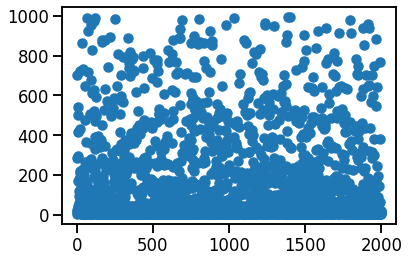

In [94]:
import matplotlib.pyplot as plt 

values = []
x = []
for i in range(2000):
    values.append(loguniform_int(2, 1000).rvs())
    x.append(i)

plt.scatter(x, values)


Now, we can define the randomized search using the different distributions.
Executing 10 iterations of 5-fold cross-validation for random
parametrizations of this model on this dataset can take from 10 seconds to
several minutes, depending on the speed of the host computer and the number
of available processors.

In [21]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'classifier__l2_regularization': loguniform(1e-6, 1e3),
    'classifier__learning_rate': loguniform(0.001, 10),
    'classifier__max_leaf_nodes': loguniform_int(2, 256),
    'classifier__min_samples_leaf': loguniform_int(1, 100),
    'classifier__max_bins': loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    model, param_distributions=param_distributions, n_iter=10,
    cv=5, verbose=1,
)
model_random_search.fit(data_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 4min 11s, sys: 5.73 s, total: 4min 17s
Wall time: 1min 12s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                sparse_threshold=0,
                                                                transformers=[('cat_preprocessor',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['workclass',
                                                                                'education',
                                                                                'marital-status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native-country'])])),
                                             ('classifier',
                                              Hi...
                   param_distributions={'classifier__l2_regularization': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8a5bb90ee0>,
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8a5a3f58b0>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x7f8a5a3f2640>,
                                        'classifier__max_leaf_nodes': <__main__.loguniform_int object at 0x7f8a5a3f2a60>,
                                        'classifier__min_samples_leaf': <__main__.loguniform_int object at 0x7f8a5a39ffd0>},
                   verbose=1)

Then, we can compute the accuracy score on the test set.

In [32]:
accuracy = model_random_search.score(data_test, target_test)

print(f"The test accuracy score of the best model is "
      f"{accuracy:.2f}")

The test accuracy score of the best model is 0.86


In [96]:
from pprint import pprint

print("The best parameters are:")
pprint(model_random_search.best_params_)
# print(model_random_search.best_params_)

The best parameters are:
{'classifier__l2_regularization': 8.011568708610163e-06,
 'classifier__learning_rate': 0.06694856416198522,
 'classifier__max_bins': 43,
 'classifier__max_leaf_nodes': 29,
 'classifier__min_samples_leaf': 2}



We can inspect the results using the attributes `cv_results` as we did
previously.

In [34]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

In [35]:
# get the parameter names
column_results = [
    f"param_{name}" for name in param_distributions.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False)
cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
8,0.000008,0.066949,29,2,43,0.855614,0.002831,1
1,0.000018,0.014851,221,96,25,0.847998,0.002107,2
7,0.012559,1.288899,24,6,25,0.840463,0.002911,3
6,0.0061,0.321468,242,2,14,0.835686,0.001777,4
5,0.009242,0.020619,27,56,2,0.801916,0.002448,5
0,0.003296,0.001262,97,6,5,0.758947,0.000013,6
2,0.000002,0.004189,12,2,55,0.758947,0.000013,6
3,7.588086,0.003819,248,7,132,0.758947,0.000013,6
4,0.054676,0.001525,99,34,192,0.758947,0.000013,6
9,42.966463,0.001131,62,4,4,0.758947,0.000013,6


The best model that we found with this search seems to have a substantially better
mean test score than the second to best model, as the difference of the mean test
scores of both models differs by more than three times the standard deviation of the
cross-validated test scores of the best model.

In [36]:
cv_results = cv_results.set_index("rank_test_score")
cv_results["mean_test_score"][1] - cv_results["mean_test_score"][2]

0.007616487785724879

In [37]:
3 * cv_results["std_test_score"][1]

0.008492302464647421

Keep in mind that tuning is limited by the number of different combinations
of parameters that are scored by the randomized search. In fact, there might
be other sets of parameters leading to similar or better generalization
performances but that were not tested in the search.
In practice, a randomized hyperparameter search is usually run with a large
number of iterations. In order to avoid the computation cost and still make a
decent analysis, we load the results obtained from a similar search with 200
iterations.

In [ ]:
# model_random_search = RandomizedSearchCV(
#     model, param_distributions=param_distributions, n_iter=200,
#     n_jobs=2, cv=5)
# model_random_search.fit(data_train, target_train)
# cv_results =  pd.DataFrame(model_random_search.cv_results_)
# cv_results.to_csv("../figures/randomized_search_results.csv")

In [97]:
cv_results = pd.read_csv("../figures/randomized_search_results.csv",
                         index_col=0)

(cv_results[column_results].rename(
    shorten_param, axis=1).sort_values("mean_test_score", ascending=False))

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
208,0.011775,0.076653,24,2,155,0.871393,0.001588,1
343,0.000404,0.244503,15,15,229,0.871339,0.002741,2
21,4.994918,0.077047,53,7,192,0.870793,0.001993,3
328,2.036232,0.224702,28,49,236,0.869837,0.000808,4
327,4.733808,0.036786,61,5,241,0.869673,0.002417,5
...,...,...,...,...,...,...,...,...
232,0.000097,9.976823,28,5,3,0.448205,0.253714,496
413,0.000001,8.828574,64,1,144,0.448205,0.253714,497
344,0.000003,7.091079,5,1,95,0.448205,0.253714,497
200,0.000444,6.236325,2,2,30,0.344629,0.207156,499


In this case the top performing models have test scores with a high
overlap between each other, meaning that indeed, the set of parameters
leading to the best generalization performance is not unique.


In this notebook, we saw how a randomized search offers a valuable
alternative to grid-search when the number of hyperparameters to tune is more
than two. It also alleviates the regularity imposed by the grid that might be
problematic sometimes.

In the following, we will see how to use interactive plotting tools to explore
the results of large hyperparameter search sessions and gain some
insights on range of parameter values that lead to the highest performing
models and how different hyperparameter are coupled or not.